In [6]:
import pandas as pd 
import numpy as np
import scipy.stats as stats
from numba import jit
import scipy
from sklearn.metrics import jaccard_score
import time

In [8]:
u_data = pd.read_csv('u.data',names=['userId','itemId','rating','timestamp'],delimiter='\t')
u_genre = pd.read_csv('u.genre',names=['genre','genreId'],delimiter='|')
u_occupation = pd.read_csv('u.occupation',names=['occupation'])
u_user = pd.read_csv('u.user',names=['userId','age','gender','occupation','zipcode'],delimiter='|')
#u_item = pd.read_csv('u.item',names=['movieId','movieTitle','releaseDate','videoReleaseDate','IMDbId','unknown','action','adventure','animation','children','comedy','crime','documentary','drama','fantasy','filmNoir','horror','musical','mystery','romance','sciFi','thriller','war','western'],delimiter='|')

In [9]:
def split_data_ml100k(data, num_users, num_items, split_mode='random',
                      test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [
            True if x == 1 else False
            for x in np.random.uniform(0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data
train_data , test_data = split_data_ml100k(u_data,943,1682,test_ratio=0.2)

In [10]:
# master_record = pd.merge(u_data,u_user,on='userId')
# master_record_1 = pd.merge(master_record,u_item,left_on='itemId',right_on='movieId')
# master_record_1.sort_values(by=['userId','itemId'])

In [11]:
matrix = np.zeros((1682,943),dtype=int)
#u_data = pd.DataFrame(train_data).sort_values(by=[0,1]).to_numpy()

for i in train_data.to_numpy():
    matrix[i[1]-1][i[0]-1]=float(i[2])
    #print(i[2])
rated_unrated_mat = np.zeros((1682,943))
row_index = 0
col_index = 0
for i in matrix:
    for j in i:
        if j!=0:
            rated_unrated_mat[row_index][col_index]=1
        col_index+=1
    row_index+=1
    col_index = 0
matrix = matrix.transpose()
matrix.shape

(943, 1682)

In [7]:
pearson = np.ones((matrix.shape[0],matrix.shape[0]))
start = time.time()
r,p = stats.pearsonr(matrix[2],matrix[1])
#pearson[0][1] = r
end = time.time()
print(end-start)

0.01295018196105957


In [ ]:

def coef(matrix):
    pearson = np.ones((matrix.shape[0],matrix.shape[0]))
    cosine = np.ones((matrix.shape[0],matrix.shape[0]))
    jaccard = np.ones((matrix.shape[0],matrix.shape[0]))
    row = 0
    for i in matrix:
        col = 0
        for j in matrix:
            #realation = np.corrcoef(i,j)            
            r,p = stats.pearsonr(i,j)
            pearson[row,col] = r
            cosine[row,col] = 1 - scipy.spatial.distance.cosine(i,j)
            jaccard[row,col] = jaccard_score(i,j,average='macro')
            col+=1
        row+=1
    return pearson,cosine,jaccard

In [ ]:
pearson,cosine,jaccard = coef(matrix)
# pearson = pd.read_csv('pearson.csv')
# jaccard = pd.read_csv('jaccard.csv')
# cosine = pd.read_csv('cosine.csv')

In [ ]:
# with open('pearson.csv','w') as f:
#     for i in pearson:
#         for j in i:
#             f.write(str(j))
#             f.write(',')
#         f.write('\n')
# with open('cosine.csv','w') as f:
#     for i in cosine:
#         for j in i:
#             f.write(str(j))
#             f.write(',')
#         f.write('\n')
# with open('jaccard.csv','w') as f:
#     for i in pearson:
#         for j in i:
#             f.write(str(j))
#             f.write(',')
#         f.write('\n')

In [ ]:
# print('enter the user with whom most similar users are to be shown')
# user = input()
# users_pearson = pearson[int(user)-1]
# users_cosine = cosine[int(user)-1]
# users_jaccard = jaccard[int(user)-1]

In [ ]:
# bestFitUsers_pearson = (-users_pearson).argsort()[:10] +1
# bestFitUsers_cosine = (-users_cosine).argsort()[:10] +1
# bestFitUsers_jaccard = (-users_jaccard).argsort()[:10] +1

In [ ]:
# print(" pearson = ",bestFitUsers_pearson,'\n',
#     'cosine similarity',bestFitUsers_cosine,'\n'
#     ' jaccard',bestFitUsers_jaccard)

In [ ]:
np_test = test_data.to_numpy()
np_test.shape

In [ ]:
def rating_predictor(cosine,np_test,matrix,final):
    index=0
    for i in np_test:
        best_fit = (-cosine[i[0]-1]).argsort()[0:100]
        sum = 0
        n = 0
        for j in best_fit:
            # print(j)
            # print(i[1])
            if matrix[j,i[1]-1] != 0:
                sum+=matrix[j,i[1]-1]
                n+=1
        if n==0:
            for k in matrix[i[0]-1]:
                sum+=k
                n+=1
        # print(i[0],i[1],i[2],i[3])
        final[index,3]=(sum/n)
        final[index,0]=i[0]
        final[index,1]=i[1]
        final[index,2]=i[2]
        index+=1

In [ ]:
# with open('prediction.csv','w') as f:
#     for i in final:
#         for j in i:
#             f.write(str(j))
#             f.write(',')
#         f.write('\n')

In [ ]:
final_cos = np.zeros((20010,4),dtype=int)
rating_predictor(cosine,np_test,matrix,final_cos)
mae,rmse,n = 0,0,0
for i in final_cos:
    mae += abs(i[2]-i[3])
    rmse += (i[2]-i[3])**2
    n+=1
print('mean absolute error = ',mae/n)
print('root mean square error = ',(rmse/n)**0.5)

In [ ]:
final_jac = np.zeros((20010,4),dtype=int)
rating_predictor(pearson,np_test,matrix,final_jac)
mae,rmse,n = 0,0,0
for i in final_jac:
    mae += abs(i[2]-i[3])
    rmse += (i[2]-i[3])**2
    n+=1
print('mean absolute error = ',mae/n)
print('root mean square error = ',(rmse/n)**0.5)

In [ ]:
final_pear = np.zeros((20010,4),dtype=int)
rating_predictor(jaccard,np_test,matrix,final_pear)
mae,rmse,n = 0,0,0
for i in final_pear:
    mae += abs(i[2]-i[3])
    rmse += (i[2]-i[3])**2
    n+=1
print('mean absolute error = ',mae/n)
print('root mean square error = ',(rmse/n)**0.5)

In [115]:
matrix = matrix.transpose()
from dask import delayed
def cosine_item(r1,r2):
    p1 = delayed(np.sum)(r1*r2)
    r1sq = delayed(np.sum)(r1**2)
    r2sq = delayed(np.sum)(r2**2)
    den = (r1sq**0.5)*(r2sq**0.5)
    return p1/den
def item_based(matrix):
    sim = np.zeros((1682,1682))
    row = 0
    for i in matrix:
        col = 0
        for j in matrix:
            if(i%2==0):
                sim[i,j] = cosine_item(i,j)
            else:
                sim[i,j] = cosine_item(i,j)
            col+=1
        row+=1



In [116]:
total=delayed(item_based)(matrix)


In [117]:
temp = cosine_item(matrix[1],matrix[2])

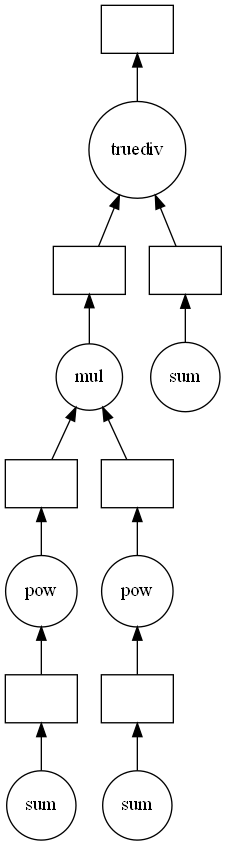

In [118]:
temp.visualize()

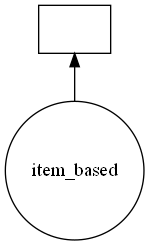

In [119]:
total.visualize()

In [114]:
%time total.compute()

KeyboardInterrupt: 